# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

  - 🤝 Breakout Room #2:
  1. Evaluating the LangGraph Application with LangSmith
  2. Adding Helpfulness Check and "Loop" Limits
  3. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies

We'll first install all our required libraries.

In [1]:
!pip install -qU langchain langchain_openai langchain-community langgraph arxiv duckduckgo_search==5.3.1b1

## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [2]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE4 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Duck Duck Go Web Search](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/ddg_search)
- [Arxiv](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/arxiv)

####🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

In [3]:
# 😀 my own cell

from langchain_core.runnables import Runnable
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langchain_community.tools.arxiv.tool import ArxivQueryRun

ddg_tool = DuckDuckGoSearchRun()
arxiv_tool = ArxivQueryRun()

# Is LangChain tool a Runnable?
print(isinstance(ddg_tool, Runnable))
print(isinstance(arxiv_tool, Runnable))

# What about the input types?
print(ddg_tool.InputType)
print(arxiv_tool.InputType)

True
True
typing.Union[str, typing.Dict, langchain_core.messages.tool.ToolCall]
typing.Union[str, typing.Dict, langchain_core.messages.tool.ToolCall]


In [4]:
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langchain_community.tools.arxiv.tool import ArxivQueryRun

# 😀 Activity #1
tool_belt = [
    DuckDuckGoSearchRun(), ArxivQueryRun()
]

### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [6]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0, name="core_llm")
model = ChatOpenAI(model="gpt-4o-mini", temperature=0, name="core_llm")

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [7]:
model = model.bind_tools(tool_belt)

In [8]:
# 😀 my own cell

# What type is the model obtained from .bind_tools() method?
type(model)

# What is the bound model?
print('bound model:')
print(model.bound)

# What is the kwargs when being automatically passed in for invocation?
print("="*20)
print('kwargs:')
print(model.kwargs)


bound model:
name='core_llm' client=<openai.resources.chat.completions.Completions object at 0x7ff85c09d750> async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7ff85c0a5690> root_client=<openai.OpenAI object at 0x7ff85c091950> root_async_client=<openai.AsyncOpenAI object at 0x7ff85c09d910> model_name='gpt-4o-mini' temperature=0.0 openai_api_key=SecretStr('**********') openai_proxy=''
kwargs:
{'tools': [{'type': 'function', 'function': {'name': 'duckduckgo_search', 'description': 'A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type': 'object', 'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query']}}}, {'type': 'function', 'function': {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology,

#### ❓ Question #1:

How does the model determine which tool to use?

### 😀😀😀 Answer to Qeustion #1
- As mentioned above, the information about tools is automatically passed in as a keyword argument by .bind_tools() method. 
- The information contains what each of the tools is, when to use as well as what are the necessary and optinal parameters for each tool.

In [9]:
# 😀 my own cell

for tool_info in model.kwargs['tools']:
    info = tool_info['function']
    print(f"name: {info['name']}\n")
    print(f"description: {info['description']}\n")
    print(f"parameters: {info['parameters']['properties']}\n")
    print("="*20)

# The model is going to look at 'description' to determine the tool to use

name: duckduckgo_search

description: A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.

parameters: {'query': {'description': 'search query to look up', 'type': 'string'}}

name: arxiv

description: A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from scientific articles on arxiv.org. Input should be a search query.

parameters: {'query': {'description': 'search query to look up', 'type': 'string'}}



## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

### 😀😀😀 I will adjust 'AgentState' below so it can be adapted to Question #2 later on 

In [9]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

# 😀 My version of AgentState 
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]
  recursion_num: int # 😀 Add this to keep track of the number of model calls

In [11]:
# 😀 my own cell

from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

msg1 = HumanMessage(content="What is the capital of France?")
msg2 = AIMessage(content="The capital of France is Paris.")

first_added_msg = add_messages(msg1, msg2)
print(first_added_msg)

msg3 = HumanMessage(content="What is the capital of Germany?")
second_added_msg = add_messages(first_added_msg, msg3)
print(second_added_msg)

msg4 = AIMessage(content="The capital of Germany is Berlin.")
third_added_msg = add_messages(second_added_msg, [msg4])
print(third_added_msg)

# We can see that add_messages appends the messages to the list and assigns mesaage_id to each message  

[HumanMessage(content='What is the capital of France?', id='f15f1a2f-7b00-47b1-b026-f572c2aa4a31'), AIMessage(content='The capital of France is Paris.', id='1316ca34-a10c-4683-bff7-3febbe0c5b26')]
[HumanMessage(content='What is the capital of France?', id='f15f1a2f-7b00-47b1-b026-f572c2aa4a31'), AIMessage(content='The capital of France is Paris.', id='1316ca34-a10c-4683-bff7-3febbe0c5b26'), HumanMessage(content='What is the capital of Germany?', id='17b52d5e-6532-44e3-8898-bf2fa63e3871')]
[HumanMessage(content='What is the capital of France?', id='f15f1a2f-7b00-47b1-b026-f572c2aa4a31'), AIMessage(content='The capital of France is Paris.', id='1316ca34-a10c-4683-bff7-3febbe0c5b26'), HumanMessage(content='What is the capital of Germany?', id='17b52d5e-6532-44e3-8898-bf2fa63e3871'), AIMessage(content='The capital of Germany is Berlin.', id='100387ad-9a93-4002-8362-94e77c9f82d1')]


## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

### 😀😀😀 I will also adjust 'call_model' below so it can be adapted to Question #2 later on 

In [21]:
from langgraph.prebuilt import ToolNode

# 😀 I will also adjust call_model so it can be adapted to Question #2 later on 
def call_model(state: AgentState):

  messages = state["messages"]
  recursion_num = state.get("recursion_num", 0)
  response = model.invoke(messages)
  return {"messages" : [response], "recursion_num": recursion_num + 1}

tool_node = ToolNode(tool_belt)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [22]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [23]:
uncompiled_graph.set_entry_point("agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [24]:
# 😀 I will also adjust should_continue so it can be adapted to Question #2 later on 

def should_continue(state: AgentState):
  last_message = state["messages"][-1]
  recursion_num = state.get("recursion_num", 0)

  print(f"Recursion number: {recursion_num}")

  if recursion_num > 10 or not last_message.tool_calls:
    return END

  return "action"

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue,    
)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [25]:
uncompiled_graph.add_edge("action", "agent")

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [26]:
compiled_graph = uncompiled_graph.compile()

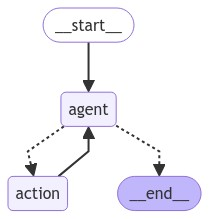

In [27]:
# 😀 My own cell
# Let's visualize the compiled graph on my own

from IPython.display import Image, display

try:
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except:
    pass

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?

If not, how could we impose a limit to the number of cycles?

### 😀😀😀 Answers to Question #2

- We can do so by adding a state called 'recursion_num' and modifying the conditional edge.

## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:



### 😀😀😀 Running the cell below, See 'Recursion number: {num}' which indicates the number of model calls associated Question #2

In [28]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="Who is the current captain of the Winnipeg Jets?")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"): # 😀 Since compiled_graph is a Runnable, it has astream method.
    # 😀 Each chunk represents 'node name' and 'state(AgentState)'
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Recursion number: 1
Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0yRyZ02yzcRwwm8IoZXvoovY', 'function': {'arguments': '{"query":"current captain of the Winnipeg Jets 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 156, 'total_tokens': 181}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2273a26b-999e-4803-8cb9-b66b8d2b45d9-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'current captain of the Winnipeg Jets 2023'}, 'id': 'call_0yRyZ02yzcRwwm8IoZXvoovY', 'type': 'tool_call'}], usage_metadata={'input_tokens': 156, 'output_tokens': 25, 'total_tokens': 181})]



Receiving update from node: 'action'
[ToolMessage(content='Adam Lowry was named captain of the Winnipeg Jets on Tuesday. ... Sep 20, 2023. Latest News. Inside look a

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [30]:
inputs = {"messages" : [HumanMessage(content="Search Arxiv for the QLoRA paper, then search each of the authors to find out their latest Tweet using DuckDuckGo.")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Recursion number: 1
Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dFsjJX9mhL8ve0TNc9MLeV5w', 'function': {'arguments': '{"query": "QLoRA"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_QA2DkpEtb3YpKent3d1gKvUr', 'function': {'arguments': '{"query": "latest Tweet"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 173, 'total_tokens': 223}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f8164be4-7016-4e89-97f4-25aec4fafafd-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'QLoRA'}, 'id': 'call_dFsjJX9mhL8ve0TNc9MLeV5w', 'type': 'tool_call'}, {'name': 'duckduckgo_search', 'args': {'query': 'latest Tweet'}, 'id': 'call_QA2DkpEtb3YpKent3d1gKvUr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 173, 'output_tokens': 50, 'total_tokens'

####🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.


### 😀😀😀 Activity #2
- I looked throuth the steps by using LangSmith

![image](langgraph_steps.png)

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [31]:
def convert_inputs(input_object: dict): # 😀 Add type hind
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state: AgentState): # 😀 Add type hind
  return input_state["messages"][-1].content

agent_chain = convert_inputs | compiled_graph | parse_output

In [32]:
agent_chain.invoke({"question" : "What is RAG?"})

Recursion number: 1


'RAG stands for Retrieval-Augmented Generation. It is a technique used in natural language processing (NLP) and machine learning to improve the performance of language models by combining retrieval-based methods with generative models. Here’s a brief overview of how it works:\n\n1. **Retrieval**: In the first step, the system retrieves relevant documents or pieces of information from a large corpus based on the input query. This is typically done using a retrieval model, such as BM25 or a dense retrieval model like DPR (Dense Passage Retrieval).\n\n2. **Augmentation**: The retrieved documents are then used to augment the input query. This means that the information from the retrieved documents is combined with the original query to provide more context and relevant information.\n\n3. **Generation**: Finally, a generative model, such as a transformer-based model like GPT-3, uses the augmented input to generate a response. The generative model can produce more accurate and contextually r

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

####🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

### 😀😀😀 Activity #3

I can do this with the help of our agent chain.

In [33]:
# 😀 My own cell

response = agent_chain.invoke({"question" : "Search Arxiv for the QLoRA paper, then provide five question-answer pairs from the paper."})

response

Recursion number: 1
Recursion number: 2


'Here are five question-answer pairs based on the QLoRA paper titled "QLoRA: Efficient Finetuning of Quantized LLMs":\n\n1. **Question:** What is QLoRA?\n   **Answer:** QLoRA is an efficient finetuning approach that reduces memory usage enough to finetune a 65B parameter model on a single 48GB GPU while preserving full 16-bit finetuning task performance. It backpropagates gradients through a frozen, 4-bit quantized pretrained language model into Low Rank Adapters (LoRA).\n\n2. **Question:** What are the key innovations introduced by QLoRA to save memory without sacrificing performance?\n   **Answer:** QLoRA introduces several innovations to save memory without sacrificing performance: (a) 4-bit NormalFloat (NF4), a new data type that is information theoretically optimal for normally distributed weights, (b) double quantization to reduce the average memory footprint by quantizing the quantization constants, and (c) paged optimizers to manage memory spikes.\n\n3. **Question:** How does Q

In [34]:
questions = [
    ### YOUR CODE HERE
    "What is QLoRA?",
    "What are the key innovations introduced by QLoRA to save memory without sacrificing performance?",
    "How does QLoRA perform compared to previous models on the Vicuna benchmark?",
    "What datasets and model types were used in the QLoRA study?",
    "What does the paper conclude about the reliability of current chatbot benchmarks?"
]

answers = [
    ### YOUR CODE HERE
    {"must_mention" : ["LoRA", "quantization"]},
    {"must_mention" : ["NF4", "double quantization", "paged optimizers"]},
    {"must_mention" : ["Vicuna", "99.3%"]},
    {"must_mention" : ["LLaMA", "datasets"]},
    {"must_mention" : ["alternative", "cheap"]},
]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [35]:
from langsmith import Client

client = Client()
dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

#### ❓ Question #3:

How are the correct answers associated with the questions?

> NOTE: Feel free to indicate if this is problematic or not

### 😀😀😀 Answer to Question #3

- Since this is not a math question, it's difficult to say that there is one correct answer.
- The five questions generated by my agent are somewhat related to the summarization of the paper.
- Therefore, a qualitative evaluation is needed, but it can be challenging.
- A wide range of evaluation criteria can be considered, such as 'LLM_as_a_judge,' 'must_mention,' or even 'human_as_a_judge.'
- Naturally, the quality of the dataset is one of the most important factors. Clearly, the dataset I created above is not of high quality; it is just for demonstration purposes. 😀
- Setting the temperature to zero might be helpful for evaluating a Q&A agent in this context because it encourages the agent to produce more accurate answers rather than focusing on creativity.

### Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [36]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

#### ❓ Question #4:

What are some ways you could improve this metric as-is?

> NOTE: Alternatively you can suggest where gaps exist in this method.

### 😀😀😀 Answer to Question #4

- Examining the must_mention(run, example) function, we can see that it relies solely on a naive 'exact match' check.
- There is no normalization process, such as decapitalization, removal of whitespace, etc., which may lead to false negatives.
    - For example, my agent mentioned 'NF4,' 'Double Quantization,' and 'Paged Optimizers,' but these were judged as 'fail' due to capitalization differences (the references are 'NF4,' 'double quantization,' and 'paged optimizers').
- To improve this metric, we should incorporate normalization processes.
- It could also be beneficial to use a lightweight LLM to check if the response contains keywords relevant to the reference keywords.

Now that we have created our custom evaluator - let's initialize our `RunEvalConfig` with it!

In [37]:
from langchain.smith import RunEvalConfig, run_on_dataset

eval_config = RunEvalConfig(
    custom_evaluators=[must_mention],
)

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [38]:
client.run_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=agent_chain,
    evaluation=eval_config,
    verbose=True,
    project_name=f"RAG Pipeline - Evaluation - {uuid4().hex[0:8]}",
    project_metadata={"version": "1.0.0"},
)

View the evaluation results for project 'RAG Pipeline - Evaluation - 8b0fe0ef' at:
https://smith.langchain.com/o/99c107dc-9be4-5ebc-9aee-41fafaa9d426/datasets/cd9bad7d-7624-49b0-aaa1-43af5d1d8f4d/compare?selectedSessions=99086618-ec48-455f-a938-58d4e4ccffac

View all tests for Dataset Retrieval Augmented Generation - Evaluation Dataset - bf20a0c5 at:
https://smith.langchain.com/o/99c107dc-9be4-5ebc-9aee-41fafaa9d426/datasets/cd9bad7d-7624-49b0-aaa1-43af5d1d8f4d
[>                                                 ] 0/5Recursion number: 1
Recursion number: 1
Recursion number: 1
Recursion number: 1
Recursion number: 1
Recursion number: 2
[------------------->                              ] 2/5Recursion number: 2
[----------------------------->                    ] 3/5Recursion number: 2
Recursion number: 2
[------------------------------------------------->] 5/5

,feedback.must_mention,error,execution_time,run_id
count,5,0,5.000000,5
unique,2,0,NaN,5
top,True,NaN,NaN,d3f8e1ec-8f36-49ae-981d-0b6820377d6e
freq,3,NaN,NaN,1
mean,NaN,NaN,5.446346,NaN
std,NaN,NaN,1.685192,NaN
min,NaN,NaN,3.522366,NaN
25%,NaN,NaN,4.039090,NaN
50%,NaN,NaN,5.445554,NaN
75%,NaN,NaN,6.861153,NaN


{'project_name': 'RAG Pipeline - Evaluation - 8b0fe0ef',
 'results': {'374aea9c-fec9-4017-9e9c-fbd28064cef3': {'input': {'question': 'What is QLoRA?'},
   'feedback': [EvaluationResult(key='must_mention', score=True, value=None, comment=None, correction=None, evaluator_info={}, feedback_config=None, source_run_id=UUID('80eff47c-d47b-4354-a81b-4f7adad9ce34'), target_run_id=None)],
   'execution_time': 3.522366,
   'run_id': 'd3f8e1ec-8f36-49ae-981d-0b6820377d6e',
   'output': "QLoRA, or Quantized Low-Rank Adaptation, is a technique used in the field of machine learning and natural language processing to fine-tune large language models efficiently. The primary goal of QLoRA is to reduce the computational and memory requirements associated with fine-tuning large models, making it more accessible and feasible for a wider range of applications.\n\nHere are some key aspects of QLoRA:\n\n1. **Quantization**: This involves reducing the precision of the model's weights, typically from 32-bit fl

## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add to our existing conditional edge to obtain the behaviour we desire.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [39]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

####🏗️ Activity #5:

Please write markdown for the following cells to explain what each is doing.

##### 😀 YOUR MARKDOWN HERE

- First, instantiate an empty graph with AgentState to be tracked throughout it.
- Then, attach two nodes, 'agent (LLM call)' and 'action (tool call)', to the graph.

In [40]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
graph_with_helpfulness_check.add_node("action", tool_node)

##### 😀 YOUR MARKDOWN HERE

- Set the agent node as the entry point.

In [41]:
graph_with_helpfulness_check.set_entry_point("agent")

##### 😀 YOUR MARKDOWN HERE
- We define a function for a conditional edge that has an additional feature:
    - If the length of messages exceeds 10, it automatically terminates the graph.
    - When our agent provides an answer that is not a tool call, it assesses the helpfulness of the answer as 'Y' or 'N' using a third LLM (GPT-4).
    - Based on the assessed helpfulness, it determines the next step: either to 'end' or 'continue.'

In [43]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def tool_call_or_helpful(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4")

  helpfulness_chain = prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "continue"

####🏗️ Activity #4:

Please write what is happening in our `tool_call_or_helpful` function!

##### 😀 YOUR MARKDOWN HERE
- The AgentState coming out of 'agent' node has there where-to-gos:
    - If the LLM returns a tool-call message, it goes to the action node REGARDLESS OF the length of messages.
    
    - If the LLM returns a normal response, the length of messages is checked:
        - If the length exceeds 10, the graph is terminated.
        - Otherwise, the helpfulness evaluation chain is invoked for the response:
            - 'Y' indicates the response is helpful, and 'N' indicates it is not.
            - The graph ends if the response is marked 'Y.'
            - If marked 'N,' the message is sent back to the LLM for a modified response.

In [44]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    tool_call_or_helpful,
    {
        "continue" : "agent",
        "action" : "action",
        "end" : END
    }
)

##### 😀 YOUR MARKDOWN HERE
- Add an edge from the 'action' node to the 'agent' node, meaning that the output of the 'action' node will always be directed back to the 'agent' node.

In [45]:
graph_with_helpfulness_check.add_edge("action", "agent")

##### 😀 YOUR MARKDOWN HERE
- Convert our graph into a LangChain runnable to leverage runnable-related features like .invoke() and .stream().

In [46]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

##### 😀 YOUR MARKDOWN HERE
- Invoke our graph with astream method.
    - Since AgentState is a dictionary with a key-value pair of 'messages' and a list of LangChain message objects, we pass in {"messages": [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}
    - Print out the output of each node.

In [47]:
inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jHFofuXGULCLUTygI5dNEd9U', 'function': {'arguments': '{"query": "LoRA machine learning"}', 'name': 'duckduckgo_search'}, 'type': 'function'}, {'id': 'call_iAo63iTyaDTmB3YzgGiwdwQV', 'function': {'arguments': '{"query": "Tim Dettmers"}', 'name': 'duckduckgo_search'}, 'type': 'function'}, {'id': 'call_vfUWO1q2zP8LZakBsi3LzKT3', 'function': {'arguments': '{"query": "Attention in machine learning"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 171, 'total_tokens': 247}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a70d18fd-10e6-46b7-8eb9-0feecea21b08-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'LoRA machine learning'}, 'id': 'call_jHFofuXGULCLUTygI5dNEd9U', 'type': 'tool_call'}, 

### Task 4: LangGraph for the "Patterns" of GenAI

Let's ask our system about the 4 patterns of Generative AI:

1. Prompt Engineering
2. RAG
3. Fine-tuning
4. Agents

In [48]:
patterns = ["prompt engineering", "RAG", "fine-tuning", "LLM-based agents"]

In [49]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print(messages["messages"][-1].content)
  print("\n\n")

**Prompt Engineering** is the process of designing and refining inputs (prompts) for generative artificial intelligence (AI) models to achieve desired outputs. This practice is crucial for optimizing AI performance in various tasks, such as generating marketing copy, answering customer inquiries, or creating content.

### Key Developments in Prompt Engineering:

1. **Early Days**: The concept can be traced back to the early days of code generation tools like CodeSmith and MyGeneration, which automated the generation of boilerplate code for common programming tasks.

2. **Language Models and Information Retrieval Systems**: The evolution of prompt engineering began with early language models and information retrieval systems.

3. **Attention Mechanisms (2015)**: The introduction of attention mechanisms revolutionized language understanding and significantly impacted prompt engineering.

4. **Large Language Models (LLMs)**: The development of LLMs like OpenAI's GPT-3, released in 2020, m

### 😀😀😀 LangSmith Traces

![patten_image1](pattern_of_genai_1.png)
![patten_image2](pattern_of_genai_2.png)
![patten_image3](pattern_of_genai_3.png)
![patten_image4](pattern_of_genai_4.png)